The task at hand is a binary classification problem, for which both a training and a validation data set are provided as csv files.
 
We would like you to: 
-         explore both data sets, note down your key observations along with a kind of summary 
-         build a classifier – a prediction model based only on the training data, with the goal of achieving the best performance possible on the validation data. 
-         visualize results and the work on this classification task.

You are allowed to process data in any way you see fit to achieve this goal. 
 
We're expecting you to use Python to complete this task.
We would like to get any code you write for this project.


In [1]:
import os
import pandas as pd 
import numpy as np

import missingno as msno
import matplotlib.pyplot as plt

import utils, config
from tests import test_validation_data

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score, roc_auc_score, plot_confusion_matrix


In [2]:
np.random.seed(1863)

In [3]:
train_data = utils.load_transformed_data(file_path=config.TRAIN_DATA_FILE,
                                         columns_to_transform=config.columns_to_transform,
                                         column_types=config.column_types)


In [4]:
validation_data = utils.load_transformed_data(file_path=config.VALIDATION_DATA_FILE,
                                         columns_to_transform=config.columns_to_transform,
                                         column_types=config.column_types)

In [5]:
# List to store names of the columns which will be dropped 
columns_to_drop = []

In [6]:
train_data.head()

,v1,v2,v3,v4,v5,v6,v7,v8,v9,v10,v11,v12,v13,v14,v15,v16,v17,classLabel
0,a,17.92,0.000054,u,-0.840182,0.522883,1.750,f,t,1,t,g,80.0,5,800000.0,t,0,no.
1,b,16.92,0.000034,y,-2.159635,0.774187,0.290,f,f,0,f,s,200.0,0,2000000.0,NaN,0,no.
2,b,31.25,0.000112,u,1.750687,0.760363,0.000,f,t,1,f,g,96.0,19,960000.0,t,0,no.
3,a,48.17,0.000133,u,4.174871,0.888963,0.335,f,f,0,f,g,0.0,120,0.0,NaN,0,no.
4,b,32.33,0.000350,u,-3.785479,0.489024,0.500,f,f,0,t,g,232.0,0,2320000.0,f,0,no.


In [7]:
validation_data.head()

,v1,v2,v3,v4,v5,v6,v7,v8,v9,v10,v11,v12,v13,v14,v15,v16,v17,classLabel
0,b,32.33,0.000750,u,0.840107,0.544982,1.585,t,f,0,t,s,420.0,0,4200000.0,NaN,1,no.
1,b,23.58,0.000179,u,-4.174396,0.864362,0.540,f,f,0,t,g,136.0,1,1360000.0,NaN,0,no.
2,b,36.42,0.000075,y,2.232226,0.627476,0.585,f,f,0,f,g,240.0,3,2400000.0,NaN,1,no.
3,b,18.42,0.001042,y,-2.469970,0.846741,0.125,t,f,0,f,g,120.0,375,1200000.0,NaN,0,no.
4,b,24.50,0.001334,y,-3.149422,0.321087,0.040,f,f,0,t,g,120.0,475,1200000.0,f,1,no.


<pre>
"v1";"v2";"v3";"v4";"v5";"v6";"v7";"v8";"v9";"v10";"v11";"v12";"v13";"v14";"v15";"v16";"v17";"classLabel"
"a";17,92;5,4e-05;"u";-0,840182024985552;0,522882590622095;1,75;"f";"t";1;"t";"g";80;5;8e+05;"t";0;"no."
</pre>

On closer look it can be noticed that float records in csv file are made with ',' which cannot be converted by pandas to float type and it is read as string.

#### It was dataframe info before transofrmation applciation
<pre>
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3700 entries, 0 to 3699
Data columns (total 18 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   v1          3661 non-null   object 
 1   v2          3661 non-null   object 
 2   v3          3700 non-null   object 
 3   v4          3636 non-null   object 
 4   v5          3700 non-null   object 
 5   v6          3700 non-null   object 
 6   v7          3700 non-null   object 
 7   v8          3700 non-null   object 
 8   v9          3700 non-null   object 
 9   v10         3700 non-null   int64  
 10  v11         3700 non-null   object 
 11  v12         3700 non-null   object 
 12  v13         3600 non-null   float64
 13  v14         3700 non-null   int64  
 14  v15         3600 non-null   float64
 15  v16         1555 non-null   object 
 16  v17         3700 non-null   int64  
 17  classLabel  3700 non-null   object 
dtypes: float64(2), int64(3), object(13)
memory usage: 520.4+ KB
</pre>

#### Below dataframe info presented after types transformation
During transformation I encountered the issue with the column 'v15'. 

In this column there are records in scientific notation like '8,00E+05'. For this case test was written

In [8]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3700 entries, 0 to 3699
Data columns (total 18 columns):
 #   Column      Non-Null Count  Dtype   
---  ------      --------------  -----   
 0   v1          3661 non-null   category
 1   v2          3661 non-null   float64 
 2   v3          3700 non-null   float64 
 3   v4          3636 non-null   category
 4   v5          3700 non-null   float64 
 5   v6          3700 non-null   float64 
 6   v7          3700 non-null   float64 
 7   v8          3700 non-null   category
 8   v9          3700 non-null   category
 9   v10         3700 non-null   int64   
 10  v11         3700 non-null   category
 11  v12         3700 non-null   category
 12  v13         3600 non-null   float64 
 13  v14         3700 non-null   int64   
 14  v15         3600 non-null   float64 
 15  v16         1555 non-null   category
 16  v17         3700 non-null   int64   
 17  classLabel  3700 non-null   category
dtypes: category(8), float64(7), int64(3)
memory usag

In [9]:
train_data.head()

,v1,v2,v3,v4,v5,v6,v7,v8,v9,v10,v11,v12,v13,v14,v15,v16,v17,classLabel
0,a,17.92,0.000054,u,-0.840182,0.522883,1.750,f,t,1,t,g,80.0,5,800000.0,t,0,no.
1,b,16.92,0.000034,y,-2.159635,0.774187,0.290,f,f,0,f,s,200.0,0,2000000.0,NaN,0,no.
2,b,31.25,0.000112,u,1.750687,0.760363,0.000,f,t,1,f,g,96.0,19,960000.0,t,0,no.
3,a,48.17,0.000133,u,4.174871,0.888963,0.335,f,f,0,f,g,0.0,120,0.0,NaN,0,no.
4,b,32.33,0.000350,u,-3.785479,0.489024,0.500,f,f,0,t,g,232.0,0,2320000.0,f,0,no.


#### Firstly, check the datasets sizes and target variable distribution

We have relatively small datasets 

In [10]:
print(f'Train data set has {train_data.shape[0]} records with {train_data.shape[1]} parameters \n\
    validation data set has {validation_data.shape[0]} records with {validation_data.shape[1]} parameters')



Train data set has 3700 records with 18 parameters 
    validation data set has 200 records with 18 parameters


In [11]:
train_data.classLabel.value_counts()

yes.    3424
no.      276
Name: classLabel, dtype: int64

In [12]:
class_weights = {0 : 276 / 3700,
                1 : 3424 / 3700
                }

In [13]:
utils.plot_categorical_variable(train_data,'classLabel', is_horizontal=True)

From the plot above it is obvious that the target variable is sever unbalanced. For better understanding the data EDA will proceed firstly. After EDA possibly data processing pipeline could be reorganized and solving imbalance in target variable would be applied before EDA. 

Since v17 differs from target in valdiation data set, I check out distribution of these two parameters on valdiation dataset.

In [14]:
utils.plot_categorical_variable(validation_data,'classLabel')

In [15]:
utils.plot_categorical_variable(validation_data,'v17')

I found that v17 parameter are the same as the target column in train dataset, but in validation dataset v17 differs from target. In validation data set v17 is distributed in equal parts and target variable has distribution 93/107, so I will assume that v17 parameter does not have essential entropy and on modeling stage it will add additional bias to a model. Thus it will be eliminated.

In [16]:
columns_to_drop.append('v17')

In [17]:
# Also, map target classes to a numbers
target_map = {"yes.": 1, "no.": 0}
train_data['classLabel'] = train_data['classLabel'].map(target_map).astype(int)
validation_data['classLabel'] = validation_data['classLabel'].map(target_map).astype(int)


In [18]:

train_data.classLabel.equals(train_data.v17)

True

In [19]:

validation_data.classLabel.equals(validation_data.v17)

False

#### Next step is to check data consistency

Using missingno library missing values will be ploted

<AxesSubplot:>

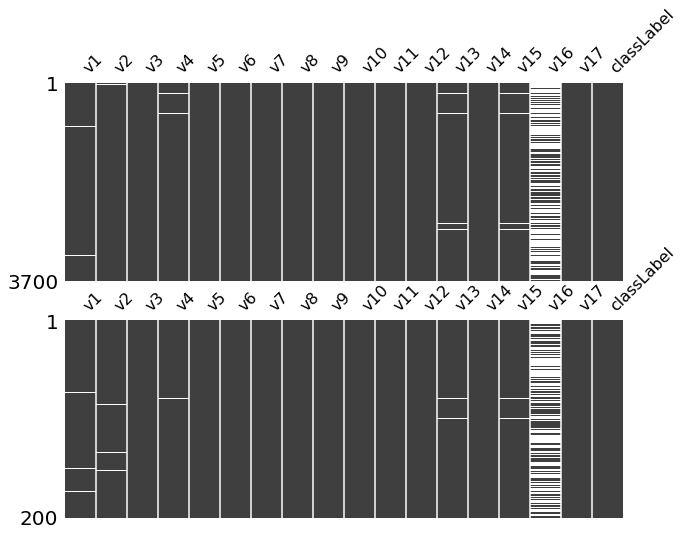

In [20]:
missing_vals_fig, axarr = plt.subplots(2, figsize=(10, 8))
msno.matrix(train_data, ax=axarr[0], sparkline=False)
msno.matrix(validation_data, ax=axarr[1], sparkline=False)

From the plots above we can notes that column v16 has lots of missing values. Let's check the ratio of NaNs in the column
As the result in v16 column there are more then 55% of missing values for both datasets. 

Since I do not know the importance of column v16 where presence of Nans is more then 55% I will drop that column and will not use imputing techniques to fill the missing values

<b>Note: </b> 

In [21]:
print(utils.get_ratio_of_nans(train_data))

            Missing Values  Percentage
v1                      39    1.054054
v2                      39    1.054054
v3                       0    0.000000
v4                      64    1.729730
v5                       0    0.000000
v6                       0    0.000000
v7                       0    0.000000
v8                       0    0.000000
v9                       0    0.000000
v10                      0    0.000000
v11                      0    0.000000
v12                      0    0.000000
v13                    100    2.702703
v14                      0    0.000000
v15                    100    2.702703
v16                   2145   57.972973
v17                      0    0.000000
classLabel               0    0.000000


In [22]:
print(utils.get_ratio_of_nans(validation_data))

            Missing Values  Percentage
v1                       3         1.5
v2                       3         1.5
v3                       0         0.0
v4                       2         1.0
v5                       0         0.0
v6                       0         0.0
v7                       0         0.0
v8                       0         0.0
v9                       0         0.0
v10                      0         0.0
v11                      0         0.0
v12                      0         0.0
v13                      3         1.5
v14                      0         0.0
v15                      3         1.5
v16                    111        55.5
v17                      0         0.0
classLabel               0         0.0


Another method from missingno library is a bulding correlation matrix of Nans in data frame. Here we can see that v13 and v15 has the same Missing values. 

First thought is to check coincidence of the columns

<AxesSubplot:>

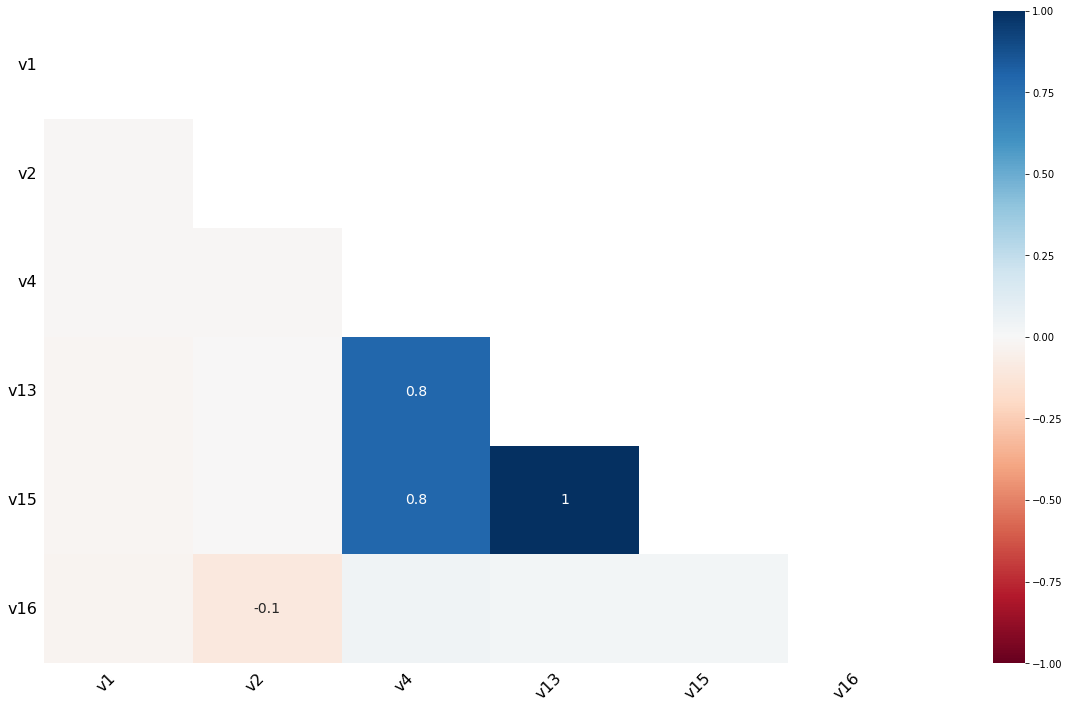

In [23]:
msno.heatmap(train_data)

Pearson correlation equals to 1 and if we look at these columns we can see that v15 and v13 only differ in unit of mesuarment. (f.e. 80.0 and 800000.0)



In [24]:
print(f"Pearson correlation coefficient between v15 and v13: {round(train_data.loc[:,'v13'].corr(train_data.loc[:,'v15']),2)}")

Pearson correlation coefficient between v15 and v13: 1.0


In [25]:
columns_to_drop.extend(['v15', 'v16'])

##### At this stage after exploring missing values two columns will be eliminated: v15 and v16
#### Next step is to explore categorical variables 

In [26]:
# v1 can be processed with dummy variable
train_data.v1.value_counts()

b    2382
a    1279
Name: v1, dtype: int64

In [27]:
# before dummy variable fill nans with presented ratios
train_data = utils.impute_categorical_by_distribution(train_data, 'v1')

In [28]:
utils.plot_grouped_bar(train_data, 'classLabel', 'v1', is_percantage=True)

From the plot above we can see that v1 classes distributed almost equaly in each of the target classes.

In [29]:
train_data = utils.get_one_hot_encode(train_data,'v1',is_dummy=True)

In [30]:
# unbalanced category with 3 classes. With assumption that this variable comprises essential information frequency encoding will be applied.
train_data.v4.value_counts()

u    3055
y     549
l      32
Name: v4, dtype: int64

v12 and v4 parameters have 3 classes each. Decided to see the dependences between these two parameters. Intersting that 94% of p class in v12 observed in l class of v4. and g class is not presented in l class of v4

In [31]:
utils.plot_grouped_bar(train_data, 'v4', 'v12', is_percantage=True)

As we can see class 'l' from v4 not presented in negative class of target variable. 85% of 'u' class observations presented in 1 class of target variable. 30% of 'y' in v4 class observed in 0 class of classLabel

In [32]:
train_data = utils.impute_categorical_by_distribution(train_data, 'v4')

In [33]:
utils.plot_grouped_bar(train_data, 'v4', 'classLabel', is_percantage=True)

The same approach to fulfill v4 missing values as v1

In [34]:
train_data = utils.frequency_encode(train_data, 'v4')

In [35]:
# v8 will be one hot encoded with dummy variable
train_data.v8.value_counts()

t    3171
f     529
Name: v8, dtype: int64

In [36]:
utils.plot_grouped_bar(train_data, 'classLabel', 'v8', is_percantage=True)

In [37]:
train_data = utils.get_one_hot_encode(train_data,'v8',is_dummy=True)

In [38]:
# also use one hot encode
train_data.v9.value_counts()

t    2239
f    1461
Name: v9, dtype: int64

In [39]:
train_data = utils.get_one_hot_encode(train_data,'v9',is_dummy=True)

In [40]:
len(train_data.v10.unique())

23

In [41]:
#train_data.v10.value_counts()
# this variable has 23 unique values, One hot is not appropriate, instead mean target encode will be applied
utils.plot_categorical_variable(train_data,'v10', is_horizontal=False)

In [42]:
train_data = utils.mean_target_encode(train_data, 'v10', 'classLabel', smoothing=1.5)

In [43]:
# v11 - one hot 
train_data.v11.value_counts()

f    1924
t    1776
Name: v11, dtype: int64

In [44]:
train_data = utils.get_one_hot_encode(train_data,'v11',is_dummy=True)

In [45]:
# there are 3 classes in v12 the same approach as for v4 will be applied - frequency encoding
train_data.v12.value_counts()

g    3430
s     189
p      81
Name: v12, dtype: int64

In [46]:
utils.plot_grouped_bar(train_data,'classLabel', 'v12', is_percantage=True)

In [47]:
train_data = utils.frequency_encode(train_data, 'v12')

In [48]:
train_data.v17.value_counts()

1    3424
0     276
Name: v17, dtype: int64

#### Countinuous and discrete variables
##### v2 v13 - variables with missing values. technique will be selected during EDA. 
Also, there are nans in v15 but this parameters will be dropped 

##### Before datailed consideration of each variable I will start with grouped scatterplot for continuous variables. Also, since I decieded to implement Random Forest classifier I won't explore correlation matrix. 

The distribution of v2 is positively skewed and a bit kurtosis, thus Nan shouldn't be fulfilled with mean. For more robustness median was selected to fill Nans in v2. Only 1% of nan are in v2 

From scatter plots there is no strong relationships between continuous variables. Also, as mentioned previously directions of the relationships can not be described or estimated. There are some extreme values in v2 and v3  

In [49]:
utils.plot_scatterplot_matrix(train_data, config.continuous_variables, 'classLabel')

In [50]:
utils.plot_histogram(train_data, 'v2', 15)

In [51]:
utils.plot_histogram_by_group(train_data, 'v2', 'classLabel', 15)

In [52]:
train_data = utils.impute_var_with_extreme(train_data, 'v2')

Another paramter with Nans is v13 - (2,7% of missing values)

From distrubution median was selected to fill Nan values.

Also, from histogram plot we can observe the presence of outliers. Since I do not know the origin of the data and meaning of the parameters I am not able to conclude that these records are outliers, because it could be extreme values which can bring a lot of information for the model 

Since I desided to use tree based algorithms Nan values will be imputed with extreme values to make tree spliting more robust.

In [53]:
max(train_data['v13']) * 5

5800.0

In [54]:
train_data.v13.describe()

count    3600.000000
mean      162.695000
std       156.045682
min         0.000000
25%         0.000000
50%       120.000000
75%       280.000000
max      1160.000000
Name: v13, dtype: float64

In [55]:
# let's check the record with max value in v13
train_data[train_data.v13 == max(train_data.v13)]

,v2,v3,v4,v5,v6,v7,v10,v12,v13,v14,v15,v16,v17,classLabel,v1_b,v8_t,v9_t,v11_t
139,40.83,0.00035,0.84027,-1.650148,0.691493,0.5,0.896947,0.051081,1160.0,0,11600000.0,f,0,0,0,0,0,0


In [56]:
utils.plot_histogram(train_data, 'v13', 15)

In [57]:
# I am not sure which class of target variable is possitive, but I decided to colored class 1 as a positive:) 
# Presence of extreme values are almost the same 
utils.plot_box_by_target_class(train_data, 'v13')

In [58]:
utils.plot_histogram_by_group(train_data, 'v13', 'classLabel', 15)

In [59]:
train_data = utils.impute_var_with_extreme(train_data, 'v13')

In [60]:
# from distribution we can not conclude anything
utils.plot_histogram_by_group(train_data, 'v5', 'classLabel', 100)

In [61]:
# from box plot absolutely the same quntiles and IQRs
utils.plot_box_by_target_class(train_data, 'v5')

In [62]:
train_data.head()

,v2,v3,v4,v5,v6,v7,v10,v12,v13,v14,v15,v16,v17,classLabel,v1_b,v8_t,v9_t,v11_t
0,17.92,0.000054,0.840270,-0.840182,0.522883,1.750,0.921467,0.927027,80.0,5,800000.0,t,0,0,0,0,1,1
1,16.92,0.000034,0.150541,-2.159635,0.774187,0.290,0.896947,0.051081,200.0,0,2000000.0,NaN,0,0,1,0,0,0
2,31.25,0.000112,0.840270,1.750687,0.760363,0.000,0.921467,0.927027,96.0,19,960000.0,t,0,0,1,0,1,0
3,48.17,0.000133,0.840270,4.174871,0.888963,0.335,0.896947,0.927027,0.0,120,0.0,NaN,0,0,0,0,0,0
4,32.33,0.000350,0.840270,-3.785479,0.489024,0.500,0.896947,0.927027,232.0,0,2320000.0,f,0,0,1,0,0,1


In [63]:
train_data.v14.describe()

count      3700.000000
mean       2246.705946
std        8708.571126
min           0.000000
25%           0.000000
50%         113.000000
75%        1059.750000
max      100000.000000
Name: v14, dtype: float64

In [64]:
utils.plot_histogram_by_group(train_data, 'v14', 'classLabel', 50)

In [65]:
utils.plot_box_by_target_class(train_data, 'v14')

### Apply transformations for validation data 
1) drop columns ['v15', 'v16', 'v17']
2) fill nan:
    - impute_categorical_by_distribution ['v1', 'v4', ]
3) categories:
    - get_one_hot_encode ['v1', 'v8', 'v9', 'v11']
    - frequency_encode ['v4', 'v12']
    - mean_target_encode ['v10']
4) continuous and discrete:
    - impute_continuous_with_extreme ['v2', 'v13']

In [66]:
### Firstly drop columns from train_data
train_data = utils.drop_columns(train_data, columns_to_drop)

Below the final structure of dataset is presented. 

In [67]:
train_data.head()

,v2,v3,v4,v5,v6,v7,v10,v12,v13,v14,classLabel,v1_b,v8_t,v9_t,v11_t
0,17.92,0.000054,0.840270,-0.840182,0.522883,1.750,0.921467,0.927027,80.0,5,0,0,0,1,1
1,16.92,0.000034,0.150541,-2.159635,0.774187,0.290,0.896947,0.051081,200.0,0,0,1,0,0,0
2,31.25,0.000112,0.840270,1.750687,0.760363,0.000,0.921467,0.927027,96.0,19,0,1,0,1,0
3,48.17,0.000133,0.840270,4.174871,0.888963,0.335,0.896947,0.927027,0.0,120,0,0,0,0,0
4,32.33,0.000350,0.840270,-3.785479,0.489024,0.500,0.896947,0.927027,232.0,0,0,1,0,0,1


In [68]:
validation_data.head()

,v1,v2,v3,v4,v5,v6,v7,v8,v9,v10,v11,v12,v13,v14,v15,v16,v17,classLabel
0,b,32.33,0.000750,u,0.840107,0.544982,1.585,t,f,0,t,s,420.0,0,4200000.0,NaN,1,0
1,b,23.58,0.000179,u,-4.174396,0.864362,0.540,f,f,0,t,g,136.0,1,1360000.0,NaN,0,0
2,b,36.42,0.000075,y,2.232226,0.627476,0.585,f,f,0,f,g,240.0,3,2400000.0,NaN,1,0
3,b,18.42,0.001042,y,-2.469970,0.846741,0.125,t,f,0,f,g,120.0,375,1200000.0,NaN,0,0
4,b,24.50,0.001334,y,-3.149422,0.321087,0.040,f,f,0,t,g,120.0,475,1200000.0,f,1,0


In [69]:
validation_data = utils.drop_columns(validation_data, cols_to_drop=columns_to_drop)

validation_data = utils.impute_categorical_by_distribution(validation_data, 'v1')
validation_data = utils.impute_categorical_by_distribution(validation_data, 'v4')

validation_data = utils.impute_var_with_extreme(validation_data, 'v2')
validation_data = utils.impute_var_with_extreme(validation_data, 'v13')

validation_data = utils.get_one_hot_encode(validation_data,['v1', 'v8', 'v9', 'v11'],is_dummy=True)

validation_data = utils.frequency_encode(validation_data, 'v4')

validation_data = utils.frequency_encode(validation_data, 'v12')

validation_data = utils.mean_target_encode(validation_data, 'v10', 'classLabel', smoothing=1.5)

In [70]:
# test if validation data has nans and compare list of columns in train and validation datasets
test_validation_data.test_no_nan_values(validation_data)
test_validation_data.test_same_columns(train_data, validation_data) 

## Modeling
Since in validation_data classLabel is presented I will consider it as test dataset, not valdiation, so I won't split train data to test and train and will work only with these two datasets

In [71]:
# split features and label column
train_features = train_data.drop('classLabel', axis=1)
train_labels = train_data['classLabel']

# split features and label column
validation_features = validation_data.drop('classLabel', axis=1)
validation_labels = validation_data['classLabel']


In [72]:
# Step 1: Scale data
train_scaler = StandardScaler()
test_scaler = StandardScaler()
train_features = train_scaler.fit_transform(train_features)
validation_features = test_scaler.fit_transform(validation_features)

In [73]:
# suprisingly class_weight implemented for Logistic regresion in sklearn 
ll_params = {'penalty' : 'l2',
             'class_weight' : class_weights
             }

In [74]:
logistic_model = utils.LogisticRegressionModel(params=ll_params)
logistic_model.fit(train_features, train_labels)
logistic_score = logistic_model.score(train_features, train_labels, roc_auc_score)

In [75]:
print(f'ROC AUC Score of Logistic Regression: {logistic_score}')

ROC AUC Score of Logistic Regression: 0.9584454997968306


In [76]:
utils.plot_roc_curve(logistic_model.model, validation_features, validation_labels, 'Logistic Regression')


In [77]:
# From confusion matrix we can see that Logistic regression has tremendous Type 1 error or FP score. 
utils.plot_confusion_matrix(logistic_model.model, validation_features, validation_labels, 'Logistic Regression')


In [78]:
rs_params = {'criterion' : 'gini',
             'n_jobs' : -1,
             'class_weight' : class_weights, 
             'bootstrap': True, 
             'max_samples': 0.8, 
             'verbose' : 0
             }

In [79]:
rf_model = utils.RandomForestModel(rs_params)
rf_hyperparams = {
    'n_estimators': [50, 100, 200, 300],
    'max_depth': [None, 5, 10, 20],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}
rf_model.random_search(train_features, train_labels, rf_hyperparams, n_iter=100, cv=5, scoring='roc_auc')

In [80]:
rf_score = rf_model.score(train_features, train_labels, roc_auc_score)


In [88]:
rf_model.model

RandomForestClassifier(class_weight={0: 0.0745945945945946,
                                     1: 0.9254054054054054},
                       max_samples=0.8, min_samples_split=10, n_estimators=300,
                       n_jobs=-1)

In [81]:
rf_score

0.9999449749424354

In [85]:
# One thing is roc_auc_score function returns 0.999 score, but in plot function firstly roc curve calculated with roc_curve and then auc calculated. WHich gives different answer: roc_auc_score: 0.999 and from function: 0.93
utils.plot_roc_curve(rf_model.model, validation_features, validation_labels, 'Random Forest')


In [83]:
# In random forest type 1 error is also huge, 36 wrongly predicted negative cases. (FP) And small type 2 error.
utils.plot_confusion_matrix(rf_model.model, validation_features, validation_labels, 'Random Forest')

### Comparison of ROC-AUC 

In [84]:
utils.compare_scores(logistic_score, rf_score, 'Logistic Regression', 'Random Forest')
